In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import seaborn as sns
import keras 
import datetime
import requests
import warnings
import keras

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import prophet

warnings.filterwarnings('ignore')

2024-03-07 11:27:28.183610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ChloeSokol/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [59]:
mat = np.empty((0, 4))
metrics = pd.DataFrame(mat)
metrics = pd.DataFrame(columns=['model', 'mae', 'mase', 'rsq'])

# Pre-processing

In [61]:
df = pd.read_csv('multivar.csv')
df = df.drop(columns=['iso_code'])
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
categorical_cols = ['continent', 'tests_units', 'season', 'location']
df = pd.get_dummies(df, columns=categorical_cols)
df = df.sort_index()
df

,total_cases,new_cases,new_deaths,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Belgium,location_Chile,location_Czechia,location_Estonia,location_France,location_Ireland,location_Israel,location_Italy,location_Malaysia,location_United States
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,0.0,0.0,0.086,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2020-03-01,16.0,0.0,0.0,0.248,0.000,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
2020-03-01,NaN,0.0,0.0,NaN,0.000,NaN,NaN,0.395,2.372,NaN,...,0,0,0,0,0,1,0,0,0,0
2020-03-01,NaN,0.0,0.0,NaN,0.000,0.000,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2020-03-01,15.0,5.0,0.0,1.587,0.529,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,4848745.0,0.0,0.0,415989.793,0.000,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2024-01-07,103436829.0,NaN,0.0,305763.910,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2024-01-14,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0


In [62]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['new_deaths']].join(lag1df)
    return df.fillna(0) 
def normalize(df):
    for col in df.columns:
        if col != 'new_deaths':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 

In [63]:
df=process(df)
df=normalize(df)
df.shape

(20209, 68)

In [64]:
df

,new_deaths,lag1_total_cases,lag1_new_cases,lag1_new_deaths,lag1_total_cases_per_million,lag1_new_cases_per_million,lag1_icu_patients_per_million,lag1_hosp_patients_per_million,lag1_weekly_icu_admissions_per_million,lag1_weekly_hosp_admissions_per_million,...,lag1_location_Belgium,lag1_location_Chile,lag1_location_Czechia,lag1_location_Estonia,lag1_location_France,lag1_location_Ireland,lag1_location_Israel,lag1_location_Italy,lag1_location_Malaysia,lag1_location_United States
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,-0.481034,-0.312464,-0.347471,-1.173051,-0.474332,-0.622425,-0.800260,-0.495616,-0.837577,...,-0.333243,-0.333243,-0.333517,-0.333517,-0.333243,-0.333243,-0.333243,-0.333243,-0.333243,-0.332601
2020-03-01,0.0,-0.481034,-0.312464,-0.347471,-1.173050,-0.474332,-0.622425,-0.800260,-0.495616,-0.837577,...,3.000668,-0.333243,-0.333517,-0.333517,-0.333243,-0.333243,-0.333243,-0.333243,-0.333243,-0.332601
2020-03-01,0.0,-0.481033,-0.312464,-0.347471,-1.173049,-0.474332,-0.622425,-0.800260,-0.495616,-0.837577,...,-0.333243,-0.333243,-0.333517,-0.333517,3.000668,-0.333243,-0.333243,-0.333243,-0.333243,-0.332601
2020-03-01,0.0,-0.481034,-0.312464,-0.347471,-1.173051,-0.474332,-0.622425,-0.800260,-0.460201,-0.813365,...,-0.333243,-0.333243,-0.333517,-0.333517,-0.333243,3.000668,-0.333243,-0.333243,-0.333243,-0.332601
2020-03-01,0.0,-0.481034,-0.312464,-0.347471,-1.173051,-0.474332,-0.622425,-0.800260,-0.495616,-0.837577,...,-0.333243,-0.333243,2.998195,-0.333517,-0.333243,-0.333243,-0.333243,-0.333243,-0.333243,-0.332601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-14,0.0,-0.481034,-0.312464,-0.347471,-1.173051,-0.474332,-0.622425,-0.800260,-0.495616,-0.837577,...,-0.333243,-0.333243,-0.333517,2.998195,-0.333243,-0.333243,-0.333243,-0.333243,-0.333243,-0.332601
2024-01-14,0.0,-0.481034,-0.312464,-0.347471,-1.173051,-0.474332,-0.535633,-0.629399,-0.495616,-0.837577,...,-0.333243,-0.333243,2.998195,-0.333517,-0.333243,-0.333243,-0.333243,-0.333243,-0.333243,-0.332601
2024-01-14,1.0,4.188005,-0.312464,-0.347471,0.517916,-0.474332,-0.622425,-0.800260,-0.495616,-0.837577,...,-0.333243,-0.333243,-0.333517,-0.333517,-0.333243,-0.333243,-0.333243,-0.333243,-0.333243,3.006459


In [65]:
def make_series(data):
    series=[]
    for i in range(len(data)-13):
        subdf=data[i:i+13]
        series.append( (subdf.index[-1], subdf['new_deaths'].values[-1], subdf.drop('new_deaths', axis=1).values))
    return series
series=make_series(df)
print(series[0][0],series[0][1].shape,series[0][2].shape)
train_size = int(len(series) * 0.7)
train, test = series[0:train_size], series[train_size:]
#train=series[:-30]
#test=series[-30:]

2020-03-01 00:00:00 () (13, 67)


# Attempt 1

## Training

In [66]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =13

In [67]:
inputs = keras.layers.Input(shape=(13,67))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 67)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12800     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [68]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14137, 13, 67)
(14137,)
Epoch 1/100
442/442 [==============================] - 11s 15ms/step - loss: 1100.5460
Epoch 2/100
442/442 [==============================] - 6s 14ms/step - loss: 1086.6292
Epoch 3/100
442/442 [==============================] - 6s 15ms/step - loss: 1080.3192
Epoch 4/100
442/442 [==============================] - 7s 16ms/step - loss: 1076.9569
Epoch 5/100
442/442 [==============================] - 8s 17ms/step - loss: 1074.8644
Epoch 6/100
442/442 [==============================] - 9s 21ms/step - loss: 1073.5190
Epoch 7/100
442/442 [==============================] - 9s 21ms/step - loss: 1072.6046
Epoch 8/100
442/442 [==============================] - 10s 22ms/step - loss: 1072.4180
Epoch 9/100
442/442 [==============================] - 9s 21ms/step - loss: 1071.6656
Epoch 10/100
442/442 [==============================] - 9s 20ms/step - loss: 1071.6322
Epoch 11/100
442/442 [==============================] - 9s 20ms/step - loss: 1071.1869
Epoch 12/100
442/442 [===

## Testing

In [69]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_pred.head()

442/442 [==============================] - 4s 6ms/step


,yhat
2020-03-01,0.634449
2020-03-01,0.463202
2020-03-01,8.348485
2020-03-01,0.711205
2020-03-01,-1.823128


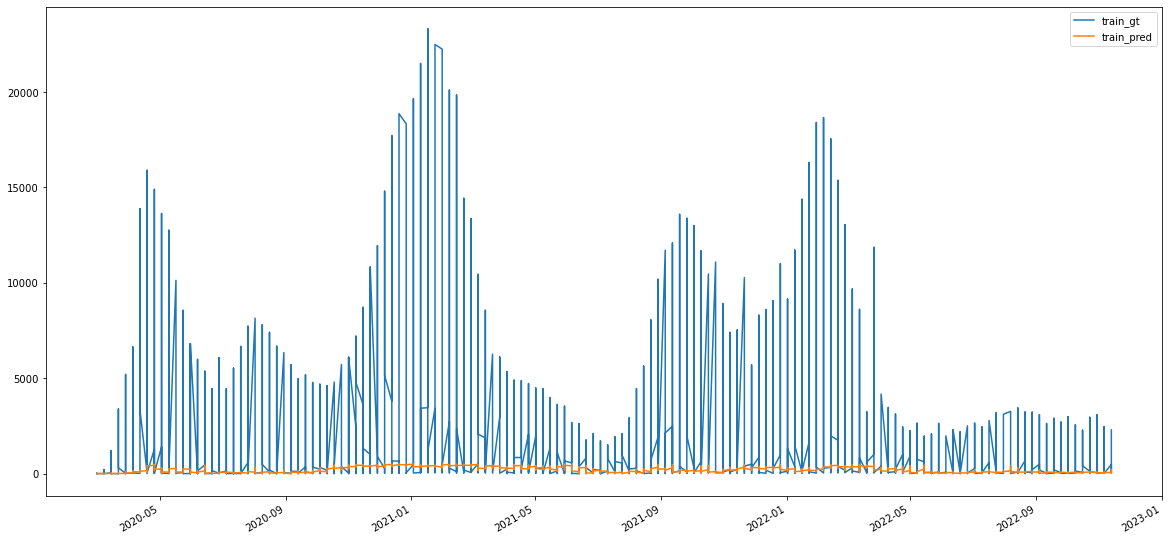

In [70]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 5ms/step


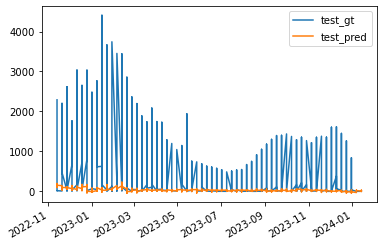

In [71]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [64]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [65]:
mae = mean_absolute_error(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
r2 = r2_score(test_gt, test_pred)
new_row = {'model': '1', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 2

## Training

In [66]:
learning_rate = 0.001
batch_size = 16
epochs = 50
sequence_length =13

In [67]:
inputs = keras.layers.Input(shape=(13,67))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 13, 67)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                12800     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [68]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14137, 13, 67)
(14137,)
Epoch 1/50
884/884 [==============================] - 15s 12ms/step - loss: 1115.3638
Epoch 2/50
884/884 [==============================] - 11s 13ms/step - loss: 1103.3679
Epoch 3/50
884/884 [==============================] - 12s 13ms/step - loss: 1097.5032
Epoch 4/50
884/884 [==============================] - 12s 13ms/step - loss: 1093.9691
Epoch 5/50
884/884 [==============================] - 12s 13ms/step - loss: 1090.7589
Epoch 6/50
884/884 [==============================] - 13s 15ms/step - loss: 1088.0253
Epoch 7/50
884/884 [==============================] - 11s 13ms/step - loss: 1085.6349
Epoch 8/50
884/884 [==============================] - 12s 13ms/step - loss: 1083.3977
Epoch 9/50
884/884 [==============================] - 13s 15ms/step - loss: 1081.5402
Epoch 10/50
884/884 [==============================] - 11s 13ms/step - loss: 1079.9910
Epoch 11/50
884/884 [==============================] - 11s 12ms/step - loss: 1078.5734
Epoch 12/50
884/884 [======

## Testing

In [69]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 3s 4ms/step


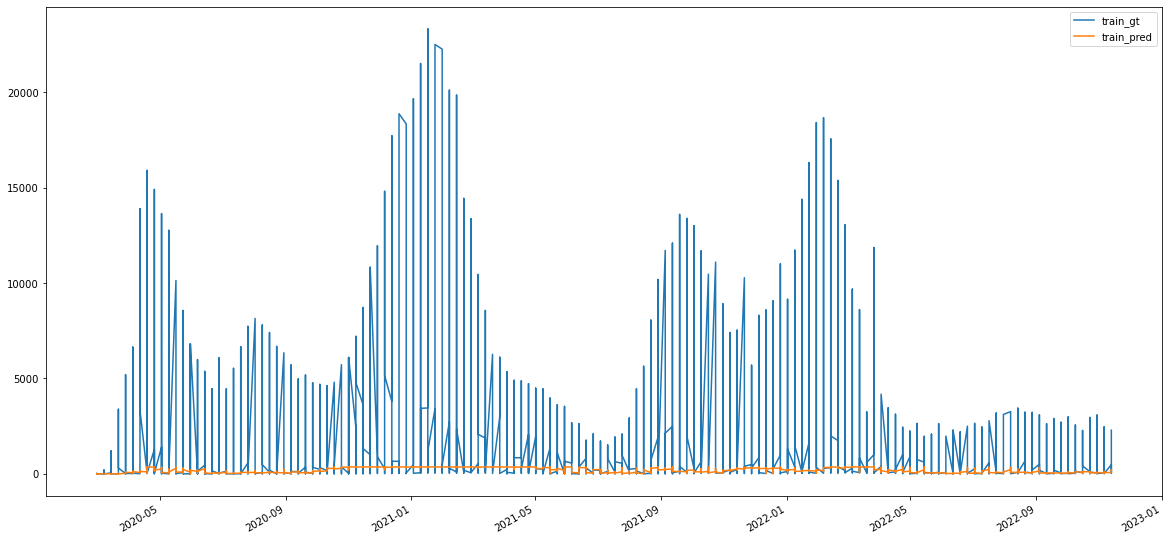

In [70]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 4ms/step


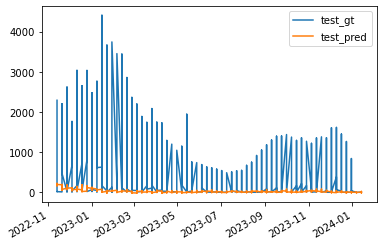

In [71]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [72]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [73]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '2', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 3

## Training

In [74]:
learning_rate = 0.001
batch_size = 16
epochs = 50
sequence_length =13

In [75]:
inputs = keras.layers.Input(shape=(13,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True)(inputs)
lstm2_out = keras.layers.LSTM(32)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 13, 67)]          0         
                                                                 
 lstm_7 (LSTM)               (None, 13, 64)            33792     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [76]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14137, 13, 67)
(14137,)
Epoch 1/50
884/884 [==============================] - 19s 16ms/step - loss: 1115.6149
Epoch 2/50
884/884 [==============================] - 14s 16ms/step - loss: 1103.9427
Epoch 3/50
884/884 [==============================] - 14s 16ms/step - loss: 1097.8469
Epoch 4/50
884/884 [==============================] - 14s 16ms/step - loss: 1094.3318
Epoch 5/50
884/884 [==============================] - 14s 15ms/step - loss: 1092.6869
Epoch 6/50
884/884 [==============================] - 14s 16ms/step - loss: 1090.5157
Epoch 7/50
884/884 [==============================] - 14s 15ms/step - loss: 1088.0493
Epoch 8/50
884/884 [==============================] - 14s 16ms/step - loss: 1085.1475
Epoch 9/50
884/884 [==============================] - 14s 16ms/step - loss: 1082.7372
Epoch 10/50
884/884 [==============================] - 13s 15ms/step - loss: 1080.7687
Epoch 11/50
884/884 [==============================] - 14s 15ms/step - loss: 1079.3109
Epoch 12/50
884/884 [======

## Testing

In [77]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 4s 7ms/step


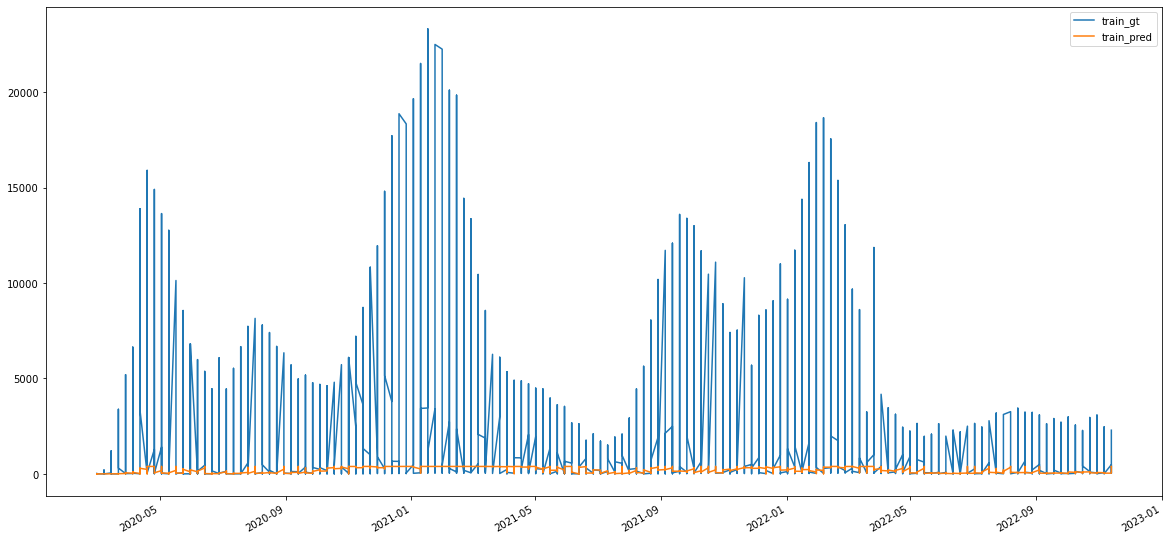

In [78]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 6ms/step


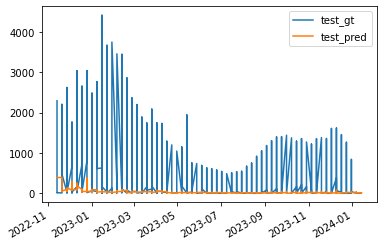

In [79]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [80]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [81]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '3', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 4

## Training

In [82]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [83]:
learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
batch_size = 16
epochs = 50
sequence_length =13

In [84]:
inputs = keras.layers.Input(shape=(13,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 13, 67)]          0         
                                                                 
 lstm_9 (LSTM)               (None, 13, 64)            33792     
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [85]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(14137, 13, 67)
(14137,)
Epoch 1/50
884/884 [==============================] - 35s 31ms/step - loss: 1115.2979
Epoch 2/50
884/884 [==============================] - 27s 31ms/step - loss: 1103.6730
Epoch 3/50
884/884 [==============================] - 27s 31ms/step - loss: 1097.8406
Epoch 4/50
884/884 [==============================] - 29s 33ms/step - loss: 1094.9180
Epoch 5/50
884/884 [==============================] - 29s 32ms/step - loss: 1093.6869
Epoch 6/50
884/884 [==============================] - 28s 31ms/step - loss: 1090.5980
Epoch 7/50
884/884 [==============================] - 28s 31ms/step - loss: 1087.9344
Epoch 8/50
884/884 [==============================] - 27s 31ms/step - loss: 1085.7113
Epoch 9/50
884/884 [==============================] - 28s 32ms/step - loss: 1084.0117
Epoch 10/50
884/884 [==============================] - 27s 31ms/step - loss: 1082.4487
Epoch 11/50
884/884 [==============================] - 27s 31ms/step - loss: 1081.0345
Epoch 12/50
884/884 [======

## Testing

In [86]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 4s 7ms/step


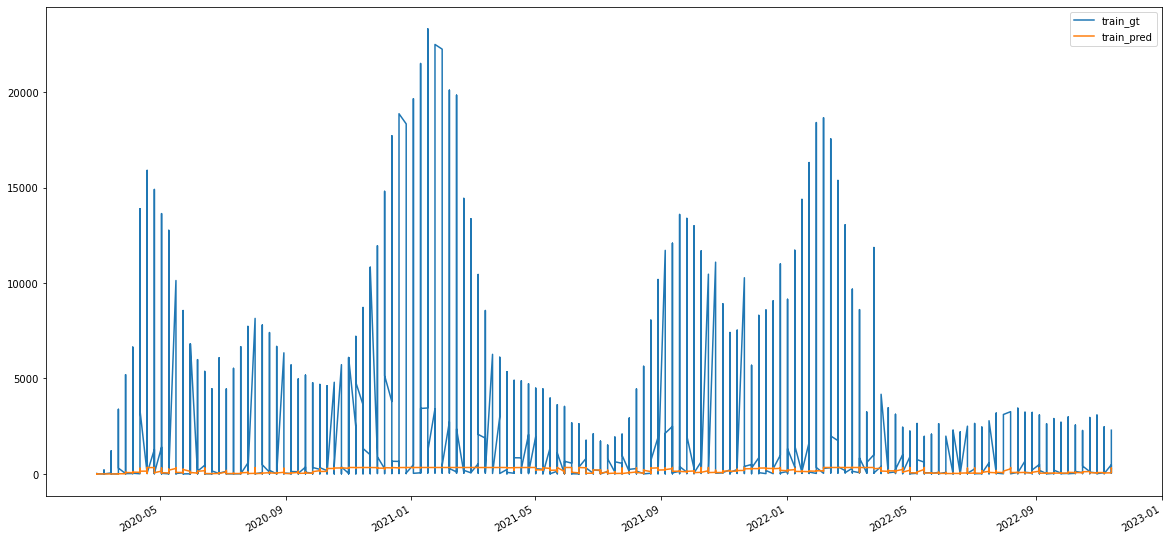

In [87]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 7ms/step


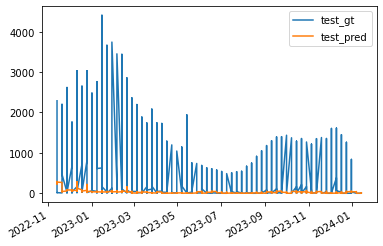

In [88]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [89]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [90]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '4', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Attempt 5

## Training

In [91]:
learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
batch_size = 16
epochs = 50
sequence_length =13

In [92]:
inputs = keras.layers.Input(shape=(13,67))
lstm1_out = keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
lstm2_out = keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)(lstm1_out)
outputs = keras.layers.Dense(1)(lstm2_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mae")
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 13, 67)]          0         
                                                                 
 lstm_11 (LSTM)              (None, 13, 64)            33792     
                                                                 
 lstm_12 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 46,241
Trainable params: 46,241
Non-trainable params: 0
_________________________________________________________________


In [93]:
x=np.array([x[2].reshape(13,67) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

(14137, 13, 67)
(14137,)
Epoch 1/50
707/707 [==============================] - 31s 32ms/step - loss: 1296.6648 - val_loss: 400.2448
Epoch 2/50
707/707 [==============================] - 23s 32ms/step - loss: 1285.5438 - val_loss: 403.2427
Epoch 3/50
707/707 [==============================] - 23s 32ms/step - loss: 1278.4821 - val_loss: 395.5220
Epoch 4/50
707/707 [==============================] - 22s 32ms/step - loss: 1273.9825 - val_loss: 394.7041
Epoch 5/50
707/707 [==============================] - 23s 32ms/step - loss: 1270.7201 - val_loss: 387.7591
Epoch 6/50
707/707 [==============================] - 22s 32ms/step - loss: 1267.8646 - val_loss: 387.7286
Epoch 7/50
707/707 [==============================] - 22s 32ms/step - loss: 1264.6654 - val_loss: 388.9529
Epoch 8/50
707/707 [==============================] - 23s 33ms/step - loss: 1261.7368 - val_loss: 389.2115
Epoch 9/50
707/707 [==============================] - 22s 32ms/step - loss: 1259.1115 - val_loss: 392.0828
Epoch 10/50


## Testing

In [94]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])

442/442 [==============================] - 4s 7ms/step


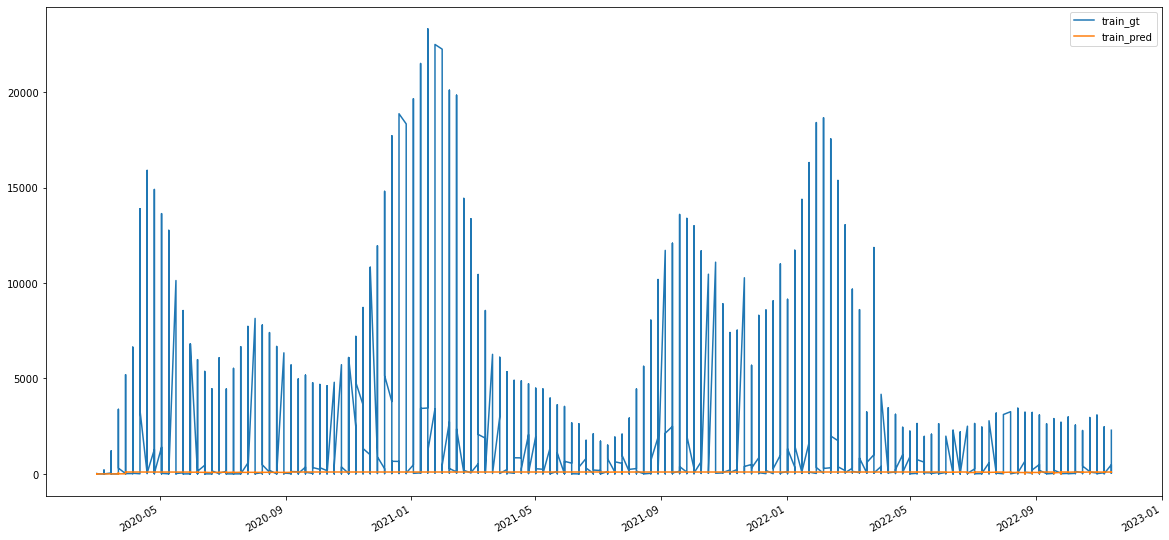

In [95]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

190/190 [==============================] - 1s 7ms/step


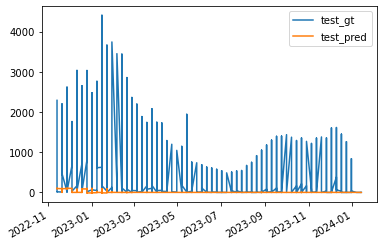

In [96]:
test_pred=model.predict(np.array([x[2].reshape(13, 67) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

## Metrics

In [97]:
y_train_values = [x[1] for x in train]
y_train = pd.DataFrame(y_train_values, columns=['y'], index=[x[0] for x in train])

In [98]:
mae = mean_absolute_error(test_gt, test_pred)
r2 = r2_score(test_gt, test_pred)
mase = MeanAbsoluteScaledError(sp = 13)
mase = mase(test_gt, test_pred, y_train = y_train)
new_row = {'model': '5', 'mae': mae, 'mase': mase, 'rsq': r2}
metrics = metrics.append(new_row, ignore_index=True)

# Results

In [99]:
metrics

,model,mae,mase,rsq
0,1,217.635031,0.117085,-0.083836
1,2,212.865631,0.114519,-0.107851
2,3,210.609484,0.113305,-0.101199
3,4,212.636148,0.114395,-0.108327
4,5,215.042698,0.11569,-0.134845


In [100]:
metrics.sort_values('mase')

,model,mae,mase,rsq
2,3,210.609484,0.113305,-0.101199
3,4,212.636148,0.114395,-0.108327
1,2,212.865631,0.114519,-0.107851
4,5,215.042698,0.11569,-0.134845
0,1,217.635031,0.117085,-0.083836
